In [1]:
import pandas as pd
import os
import matplotlib
import collections
import re
import datetime

import tensorflow as tf
import tensorboard

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import models, layers, utils
from sklearn import metrics, preprocessing

/Users/chhavichoudhury/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from transformers import TFAutoModel, AutoTokenizer

MODEL_NAME = "sentence-transformers/paraphrase-MiniLM-L3-v2"
bert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encoder = TFAutoModel.from_pretrained(MODEL_NAME)

MAX_SEQ_LEN = 512
def encode_text(text, tokenizer=bert_tokenizer, encoder=encoder):
    tokenized_input = tokenizer(
        text, 
        max_length = MAX_SEQ_LEN,
        truncation=True, 
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    
    last_hidden_state = encoder(tokenized_input["input_ids"], tokenized_input["attention_mask"]).last_hidden_state[:, 0, :]
    return last_hidden_state.numpy()[0]


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/paraphrase-MiniLM-L3-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [3]:
# Load dataframes

data_dir = os.path.join(os.getcwd(), "data")

links_path = os.path.join(data_dir, "links.csv")
movies_path = os.path.join(data_dir, "movies.csv")
ratings_path = os.path.join(data_dir, "ratings.csv")
tags_path = os.path.join(data_dir, "tags.csv")
tmdb_path = os.path.join(data_dir, "tmdb", "*")

df_tmdb_lst = []
import glob
tmbd_files = glob.glob(tmdb_path)
for file in tmbd_files:
    data = pd.read_json(file, lines=True)
    df_tmdb_lst.append(data)

df_tmdb = pd.concat(df_tmdb_lst, ignore_index=True) 
df_tmdb.drop("status", axis=1, inplace=True)

df_links = pd.read_csv(links_path)
df_movies = pd.read_csv(movies_path)
df_ratings = pd.read_csv(ratings_path)
df_tags = pd.read_csv(tags_path)

In [4]:
print(df_links.shape)
print(df_movies.shape)
print(df_ratings.shape)
print(df_tags.shape)
print(df_tmdb.shape)

(9742, 3)
(9742, 3)
(100836, 4)
(3683, 4)
(9621, 11)


In [5]:
# There are altleast 20 ratings given by any user. Same user might have given a different tag to the movie at different times.
# df_tags[["userId", "movieId", "tag"]].groupby(["userId", "movieId"]).value_counts()

# Feature Engineering

## User and Movie Statistics

In [6]:
def get_user_and_movie_statistic_features(df_ratings):
    df_avg_user_ratings = df_ratings[["rating", "userId"]].groupby("userId").mean().reset_index()
    df_avg_user_ratings.rename(columns={"rating": "avg_user_rating"}, inplace=True)
    
    df_median_user_ratings = df_ratings[["rating", "userId"]].groupby("userId").median().reset_index()
    df_median_user_ratings.rename(columns={"rating": "median_user_rating"}, inplace=True)
    
    df_avg_movie_ratings = df_ratings[["rating", "movieId"]].groupby("movieId").mean().reset_index()
    df_avg_movie_ratings.rename(columns={"rating": "avg_movie_rating"}, inplace=True)
    
    df_median_movie_ratings = df_ratings[["rating", "movieId"]].groupby("movieId").median().reset_index()
    df_median_movie_ratings.rename(columns={"rating": "median_movie_rating"}, inplace=True)

    return df_avg_user_ratings, df_median_user_ratings, df_avg_movie_ratings, df_median_movie_ratings

In [7]:
# process tags
def process_tags_df(df_tags):
    df_tags.rename(columns={"timestamp": "tag_timestamp"}, inplace=True)
    
    def append_tags(df):
        return "[SEP]".join(df.tag.values)
    
    df_tags = df_tags.groupby(["userId", "movieId"]).apply(append_tags).reset_index().rename(columns={0: "tag"})
    return df_tags

In [8]:
# process df_movies

def process_movies_dataframe(df_movies):
    df_movies['genres'] = df_movies['genres'].str.split('|')
    dfx = pd.get_dummies(pd.DataFrame(df_movies['genres'].tolist()).stack()).groupby(level=0).sum(0)
    dfx.drop("(no genres listed)", axis=1, inplace=True)
    # (no genres listed) has very small counts, likely does not have much information to offer
    
    df_movies = pd.concat([df_movies, dfx], axis=1).drop(columns=['genres'])
    
    def get_movie_name(x):
        # Extract title. 
        # Ariel (1990) -> Ariel
        matched = re.match("(.*) \([0-9]{4}\)", x)
        if not matched:
            return x
        return matched.groups(0)[0]
        
    df_movies["title"] = df_movies["title"].map(lambda x: get_movie_name(x))
    return df_movies

In [9]:
# process df_tmdb

def process_df_tmdb(df_tmdb):
    # featurize languages.
    df_tmdb["spoken_languages"] = df_tmdb["spoken_languages"].apply(lambda x: x.split("|"))
    
    all_languages_lst = df_tmdb["spoken_languages"].tolist()
    
    all_languages = []
    for lang_lst in all_languages_lst:
        all_languages.extend(lang_lst)
    
    lang_mapp = collections.Counter(all_languages)
    columns_names_to_lang_map = {lang: f"lang_{lang}" for lang, mentions in lang_mapp.items() if mentions > 500}
    frequent_languages = list(columns_names_to_lang_map.keys())
    
    for lang, lang_column in columns_names_to_lang_map.items():
        df_tmdb[lang_column] = df_tmdb["spoken_languages"].map(lambda x: int(lang in x))
    
    df_tmdb["lang_other"] = df_tmdb["spoken_languages"].map(lambda x: int(bool(set(x).difference(set(frequent_languages)))))
    
    df_tmdb.drop("spoken_languages", axis=1, inplace=True)
    
    # featurize time feautres
    df_tmdb["release_date"] = df_tmdb.release_date.map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    df_tmdb["release_year"] = df_tmdb["release_date"].map(lambda x: x.year)
    df_tmdb["release_month"] = df_tmdb["release_date"].map(lambda x: x.month)
    df_tmdb["days_since_release"] = df_tmdb["release_date"].map(lambda x: (x.today() - x).days )
    df_tmdb.drop("release_date", axis=1, inplace=True)
    return df_tmdb

In [10]:
def create_movies_features_df(df_tmdb, df_movies, df_links, df_avg_movie_ratings, df_median_movie_ratings):
    # merge movies data

    movies_data =  pd.merge(
                                pd.merge(
                                    pd.merge(df_tmdb, 
                                                pd.merge(df_movies, df_links, on="movieId"),
                                                left_on = "id", right_on = "tmdbId", how = "left"
                                            ),
                                    df_avg_movie_ratings, on="movieId", how = "left",
                                ),
                                df_median_movie_ratings, on="movieId", how = "left"
                        )
    SEP = "[SEP]"
    def concat_text(x):
        return x["title"] + SEP + str(x["original_title"]) + SEP + x["overview"] + SEP + x["tagline"] + x["cast"].replace("|", SEP)
    
    movies_data["all_text_conca"] = movies_data.apply(lambda x: concat_text(x), axis=1)
    
    movies_data.drop(["original_title", "overview", "tagline", "cast"], axis=1, inplace=True)

    tmp = movies_data["all_text_conca"].map(lambda x : encode_text(x))
    tmp = pd.DataFrame(tmp).all_text_conca.apply(pd.Series)
    tmp.columns = [f"enc{c}" for c in tmp.columns]
    movies_data = pd.concat([movies_data, tmp], axis=1)
    movies_data.drop(["all_text_conca"], axis=1, inplace=True)

    return movies_data

In [11]:
def prep_ratings_dataframe(df_ratings):
    # normalize ratings by user

    tmp = df_ratings.pivot_table(index="userId", columns="movieId", values="rating")
    tmp = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(tmp.values), 
    columns=tmp.columns, index=tmp.index)
    tmp = tmp.unstack().reset_index(name='value').rename(columns = {"value": "rating"}).dropna()
    df_ratings = pd.merge(df_ratings.rename(columns = {"rating": "org_rating"}), 
                          tmp, on=["movieId", "userId"], how="inner")
    return df_ratings

In [12]:
def create_user_features(df_ratings, df_movies, df_avg_user_ratings, df_median_user_ratings):
    
    user_df = pd.merge(df_ratings[["userId", "movieId"]], df_movies, on="movieId").drop(["title", "movieId"], axis=1)
    # normalize user interest in genre.
    
    user_df = user_df.groupby("userId").mean().reset_index()
    user_data = pd.merge(
                    pd.merge(user_df, 
                             df_avg_user_ratings, on="userId"), 
                    df_median_user_ratings, on="userId")
    
    all_genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
           'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    user_data.rename(columns = {genre: f"user_{genre}" for genre in all_genres}, inplace=True)
    
    return user_data

# Data split by time (Leave one last/ Temporal user)

In [13]:
def create_data_splits(df_ratings):
    df_rating_sorted_by_time = df_ratings.sort_values(by=["timestamp"], ascending=False).groupby("userId").cumcount(ascending=True).reset_index().rename(columns={0: "rank"})
    df_rating_sorted_by_time = pd.merge(df_rating_sorted_by_time, df_ratings.reset_index(), on="index")
    df_rating_sorted_by_time.drop("index", axis=1, inplace=False)
    
    # count 99616
    train_ratings = df_rating_sorted_by_time[df_rating_sorted_by_time["rank"] > 1].drop(["index", "rank"], axis=1)
    
    # count 610
    val_ratings = df_rating_sorted_by_time[df_rating_sorted_by_time["rank"]==1].drop(["index", "rank"], axis=1)
    
    # count 610
    test_ratings = df_rating_sorted_by_time[df_rating_sorted_by_time["rank"]==0].drop(["index", "rank"], axis=1)
    
    return train_ratings, val_ratings, test_ratings

In [14]:
def join_ratings_with_user_and_movie_data(df_ratings, movies_data, user_data):
    df_ratings = pd.merge(pd.merge(df_ratings, user_data, on="userId", how="left"),
                          movies_data, on="movieId", how="left").drop(["imdbId", "tmdbId"], axis=1).fillna(0.)
    return df_ratings

In [15]:
(df_avg_user_ratings, 
 df_median_user_ratings, 
 df_avg_movie_ratings, 
 df_median_movie_ratings) = get_user_and_movie_statistic_features(df_ratings)

df_tags = process_tags_df(df_tags)
df_movies = process_movies_dataframe(df_movies)
df_tmdb = process_df_tmdb(df_tmdb)

movies_data = create_movies_features_df(df_tmdb, df_movies, df_links, df_avg_movie_ratings, df_median_movie_ratings)
all_movie_columns = [col for col in list(movies_data.columns) if col not in ["id", "movieId", "tmdbId", "imdbId", "title"]]

df_ratings = prep_ratings_dataframe(df_ratings)

user_data = create_user_features(df_ratings, df_movies, df_avg_user_ratings, df_median_user_ratings)
all_user_columns = list(user_data.columns)
all_user_columns.remove("userId")

train_ratings, val_ratings, test_ratings = create_data_splits(df_ratings)

df_train = join_ratings_with_user_and_movie_data(train_ratings, movies_data, user_data)
df_val = join_ratings_with_user_and_movie_data(val_ratings, movies_data, user_data)
df_test = join_ratings_with_user_and_movie_data(test_ratings, movies_data, user_data)

In [16]:
len(all_user_columns + all_movie_columns)

439

In [55]:
len(all_user_columns)

21

In [17]:
all_user_columns

['user_Action',
 'user_Adventure',
 'user_Animation',
 'user_Children',
 'user_Comedy',
 'user_Crime',
 'user_Documentary',
 'user_Drama',
 'user_Fantasy',
 'user_Film-Noir',
 'user_Horror',
 'user_IMAX',
 'user_Musical',
 'user_Mystery',
 'user_Romance',
 'user_Sci-Fi',
 'user_Thriller',
 'user_War',
 'user_Western',
 'avg_user_rating',
 'median_user_rating']

In [54]:
len(all_movie_columns)

418

In [18]:
all_movie_columns[:50]

['popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'lang_en',
 'lang_it',
 'lang_es',
 'lang_de',
 'lang_fr',
 'lang_other',
 'release_year',
 'release_month',
 'days_since_release',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'avg_movie_rating',
 'median_movie_rating',
 'enc0',
 'enc1',
 'enc2',
 'enc3',
 'enc4',
 'enc5',
 'enc6',
 'enc7',
 'enc8',
 'enc9',
 'enc10',
 'enc11',
 'enc12',
 'enc13',
 'enc14',
 'enc15']

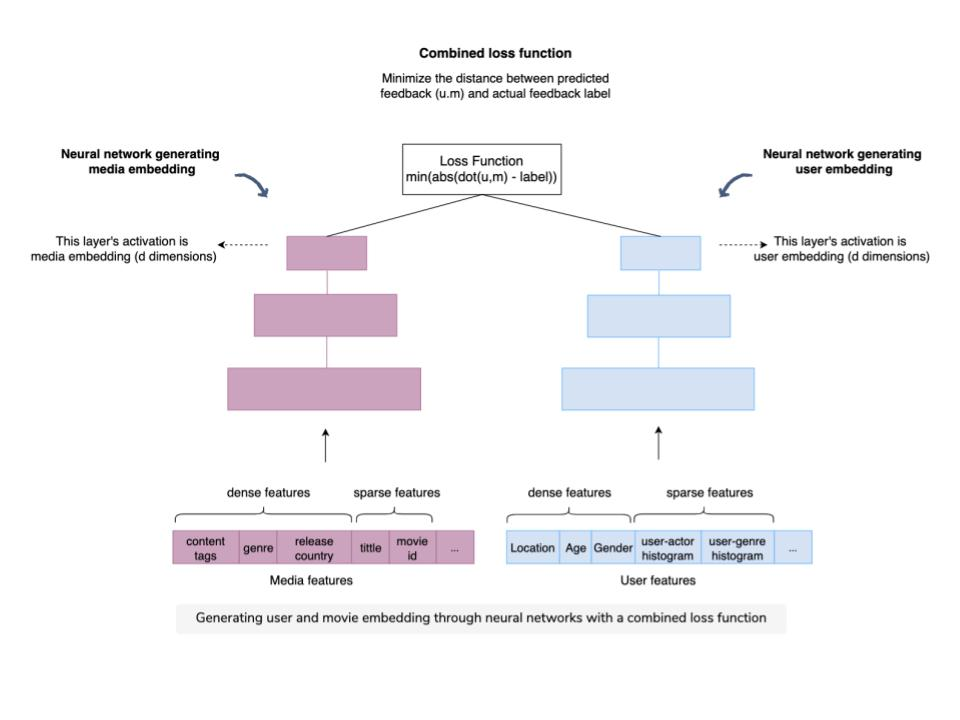

In [19]:
from PIL import Image
from IPython.display import display
img = Image.open('./model.jpg')
display(img)

In [20]:
class RecommendationModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        self.movie_layer1 = tf.keras.layers.Dense(400, name="movie_layer1", activation='relu')
        self.movie_layer2 = tf.keras.layers.Dense(300, name="movie_layer2", activation='relu')
        self.movie_layer3 = tf.keras.layers.Dense(200, name="movie_layer3", activation='relu')
        self.movie_layer4 = tf.keras.layers.Dense(100, name="movie_layer4", activation='relu')
        self.movie_dropout = layers.Dropout(0.05)
        
        self.user_layer1 = tf.keras.layers.Dense(400, name="user_layer1", activation='relu')
        self.user_layer2 = tf.keras.layers.Dense(300, name="user_layer2", activation='relu')
        self.user_layer3 = tf.keras.layers.Dense(200, name="user_layer3", activation='relu')
        self.user_layer4 = tf.keras.layers.Dense(100, name="user_layer4", activation='relu')
        self.user_dropout = layers.Dropout(0.05)

        self.dot_product = layers.Dot(name = 'dot_product', normalize=True, axes=1)
        self.out = layers.Dense(name="y_out", units=1, activation='linear')

    def call(self, inputs, training=False):

        user_features, movie_features = inputs[0], inputs[1]
        
        user_features = self.user_dropout(self.user_layer1(user_features))
        user_features = self.user_dropout(self.user_layer2(user_features))
        user_features = self.user_dropout(self.user_layer3(user_features))
        user_features = self.user_dropout(self.user_layer4(user_features))
        user_features = self.user_dropout(user_features)
        
        movie_features = self.movie_dropout(self.movie_layer1(movie_features))
        movie_features = self.movie_dropout(self.movie_layer2(movie_features))
        movie_features = self.movie_dropout(self.movie_layer3(movie_features))
        movie_features = self.movie_dropout(self.movie_layer4(movie_features))
        movie_features = self.movie_dropout(movie_features)
        return self.out(self.dot_product([user_features, movie_features]))


In [65]:
# HyperParameter Tuning

all_histories = []
for lr in [0.005, 0.001, 0.002]:
    
    model = RecommendationModel()
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=lr, global_clipnorm=1.0), 
                  loss='mean_absolute_error', 
                  metrics=['mean_absolute_percentage_error'], 
                  run_eagerly=True)

    # Define Callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=2, min_lr=0.001)
    save_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                            filepath=f"./saved_artifacts/saved_checkpoint/checkpoint_{lr}",
                            save_weights_only=True,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True
                        )
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./saved_artifacts/tb_logs_{lr}")
    
    history = model.fit([df_train[all_user_columns], df_train[all_movie_columns]], y = df_train["rating"],
                         validation_data=([df_val[all_user_columns], df_val[all_movie_columns]], df_val["rating"]),
                          epochs = 30,
                          shuffle=True,
                          callbacks = [reduce_lr, save_checkpoint, tb_callback],
                          verbose = 1, )
    
    all_histories.append(history)

Epoch 1/30
3113/3113 [==============================] - 97s 31ms/step - loss: 0.1434 - mean_absolute_percentage_error: 20.7084 - val_loss: 0.1313 - val_mean_absolute_percentage_error: 18.4319 - lr: 0.0050
Epoch 2/30
3113/3113 [==============================] - 97s 31ms/step - loss: 0.1281 - mean_absolute_percentage_error: 19.0196 - val_loss: 0.1334 - val_mean_absolute_percentage_error: 18.4603 - lr: 0.0050
Epoch 3/30
3113/3113 [==============================] - 97s 31ms/step - loss: 0.1228 - mean_absolute_percentage_error: 17.7900 - val_loss: 0.1152 - val_mean_absolute_percentage_error: 15.3162 - lr: 0.0050
Epoch 4/30
3113/3113 [==============================] - 94s 30ms/step - loss: 0.1111 - mean_absolute_percentage_error: 15.5899 - val_loss: 0.1110 - val_mean_absolute_percentage_error: 15.3680 - lr: 0.0050
Epoch 5/30
3113/3113 [==============================] - 98s 31ms/step - loss: 0.1099 - mean_absolute_percentage_error: 15.3138 - val_loss: 0.1093 - val_mean_absolute_percentage_err

Epoch 1/30
3113/3113 [==============================] - 101s 32ms/step - loss: 0.1254 - mean_absolute_percentage_error: 17.2730 - val_loss: 0.1223 - val_mean_absolute_percentage_error: 17.8552 - lr: 0.0010
Epoch 2/30
3113/3113 [==============================] - 100s 32ms/step - loss: 0.1111 - mean_absolute_percentage_error: 15.3250 - val_loss: 0.1183 - val_mean_absolute_percentage_error: 16.1920 - lr: 0.0010
Epoch 3/30
3113/3113 [==============================] - 101s 32ms/step - loss: 0.1098 - mean_absolute_percentage_error: 15.1085 - val_loss: 0.1105 - val_mean_absolute_percentage_error: 14.9841 - lr: 0.0010
Epoch 4/30
3113/3113 [==============================] - 101s 33ms/step - loss: 0.1089 - mean_absolute_percentage_error: 14.9665 - val_loss: 0.1122 - val_mean_absolute_percentage_error: 14.9828 - lr: 0.0010
Epoch 5/30
3113/3113 [==============================] - 91s 29ms/step - loss: 0.1085 - mean_absolute_percentage_error: 14.9112 - val_loss: 0.1094 - val_mean_absolute_percentage

Epoch 1/30
3113/3113 [==============================] - 98s 32ms/step - loss: 0.1664 - mean_absolute_percentage_error: 23.2449 - val_loss: 0.1303 - val_mean_absolute_percentage_error: 18.4172 - lr: 0.0020
Epoch 2/30
3113/3113 [==============================] - 97s 31ms/step - loss: 0.1279 - mean_absolute_percentage_error: 19.0650 - val_loss: 0.1299 - val_mean_absolute_percentage_error: 18.4114 - lr: 0.0020
Epoch 3/30
3113/3113 [==============================] - 91s 29ms/step - loss: 0.1279 - mean_absolute_percentage_error: 19.0527 - val_loss: 0.1319 - val_mean_absolute_percentage_error: 18.4401 - lr: 0.0020
Epoch 4/30
3113/3113 [==============================] - 91s 29ms/step - loss: 0.1279 - mean_absolute_percentage_error: 19.0527 - val_loss: 0.1304 - val_mean_absolute_percentage_error: 18.4172 - lr: 0.0020
Epoch 5/30
3113/3113 [==============================] - 92s 29ms/step - loss: 0.1279 - mean_absolute_percentage_error: 19.0704 - val_loss: 0.1302 - val_mean_absolute_percentage_err

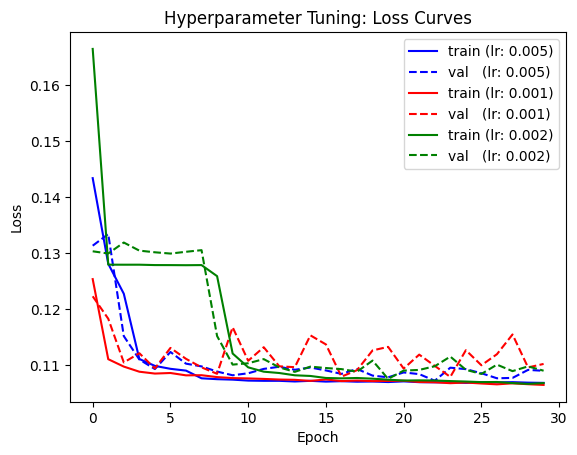

In [107]:
import matplotlib.pyplot as plt
colors = ['b', 'r', 'g']

for lr, color, this_history in zip([0.005, 0.001, 0.002], colors, all_histories):
    train_loss = this_history.history['loss']
    val_loss = this_history.history['val_loss']
    
    plt.plot(train_loss, f"{color}", label=f'train (lr: {lr})')
    plt.plot(val_loss, f"{color}--", label=f'val   (lr: {lr})')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Hyperparameter Tuning: Loss Curves")

plt.legend(loc="upper right")
plt.show()


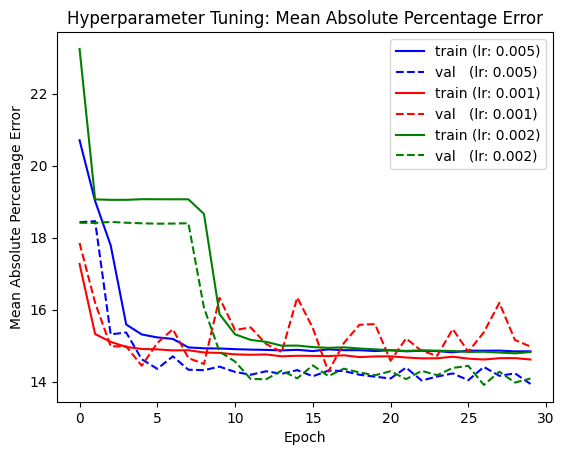

In [108]:
import matplotlib.pyplot as plt
colors = ['b', 'r', 'g']
for lr, color, this_history in list(zip([0.005, 0.001, 0.002], colors, all_histories)):
    train_mean_absolute_percentage_error = this_history.history['mean_absolute_percentage_error'] 
    val_mean_absolute_percentage_error =  this_history.history['val_mean_absolute_percentage_error']
    
    plt.plot(train_mean_absolute_percentage_error, f"{color}", label=f'train (lr: {lr})')
    plt.plot(val_mean_absolute_percentage_error, f"{color}--", label=f'val   (lr: {lr})')

plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Percentage Error")
plt.title("Hyperparameter Tuning: Mean Absolute Percentage Error")

plt.legend(loc="upper right")
plt.show()

In [22]:
model.summary()

Model: "recommendation_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 movie_layer1 (Dense)        multiple                  167600    
                                                                 
 movie_layer2 (Dense)        multiple                  120300    
                                                                 
 movie_layer3 (Dense)        multiple                  60200     
                                                                 
 movie_layer4 (Dense)        multiple                  20100     
                                                                 
 dropout_10 (Dropout)        multiple                  0         
                                                                 
 user_layer1 (Dense)         multiple                  8800      
                                                                 
 user_layer2 (Dense)         multiple         

In [57]:
# evalute on test set

model.evaluate(
    [df_test[all_user_columns], df_test[all_movie_columns]], y = df_test["rating"],
    verbose='auto',
)

20/20 [==============================] - 0s 5ms/step - loss: 0.1330 - mean_absolute_percentage_error: 19.3169


[0.132950559258461, 19.316890716552734]

In [109]:
# Train on the complete (train +val) dataset
# use test set as validation set since we still need to know which is the best checkpoint that has the lowest generalization error.

lr = 0.005

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.005, global_clipnorm=1.0), 
              loss='mean_absolute_error', 
              metrics=['mean_absolute_percentage_error'], 
              run_eagerly=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                        filepath="./saved_artifacts/saved_checkpoint/checkpoint",
                        save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True
                    )

df_train_all = pd.concat([df_train, df_val], axis=0)
history = model.fit([df_train_all[all_user_columns], df_train_all[all_movie_columns]], y = df_train_all["rating"],
                    validation_data=([df_test[all_user_columns], df_test[all_movie_columns]], df_test["rating"]),
                      epochs = 30,
                      shuffle=True,
                      callbacks = [reduce_lr, save_checkpoint],
                      verbose = 1, )

Epoch 1/30
3133/3133 [==============================] - 96s 31ms/step - loss: 0.1181 - mean_absolute_percentage_error: 16.6307 - val_loss: 0.1120 - val_mean_absolute_percentage_error: 16.0173 - lr: 0.0050
Epoch 2/30
3133/3133 [==============================] - 94s 30ms/step - loss: 0.1118 - mean_absolute_percentage_error: 15.5164 - val_loss: 0.1139 - val_mean_absolute_percentage_error: 15.3039 - lr: 0.0050
Epoch 3/30
3133/3133 [==============================] - 96s 31ms/step - loss: 0.1102 - mean_absolute_percentage_error: 15.2031 - val_loss: 0.1214 - val_mean_absolute_percentage_error: 17.6368 - lr: 0.0050
Epoch 4/30
3133/3133 [==============================] - 98s 31ms/step - loss: 0.1078 - mean_absolute_percentage_error: 14.8075 - val_loss: 0.1143 - val_mean_absolute_percentage_error: 16.2748 - lr: 0.0010
Epoch 5/30
3133/3133 [==============================] - 93s 30ms/step - loss: 0.1079 - mean_absolute_percentage_error: 14.7906 - val_loss: 0.1141 - val_mean_absolute_percentage_err

In [116]:
# Save model
import pickle

model.load_weights("./saved_artifacts/saved_checkpoint/checkpoint")
model.save("./saved_artifacts/model")

user_data.to_pickle("./saved_artifacts/user_data")
movies_data.to_pickle("./saved_artifacts/movies_data")

with open("./saved_artifacts/all_movie_columns.pkl", 'wb') as f:
    pickle.dump(all_movie_columns, f)

with open( "./saved_artifacts/all_user_columns.pkl", 'wb') as f:
    pickle.dump(all_user_columns, f)

df_ratings = pd.read_csv(ratings_path)
unwatched_movies = df_ratings.groupby(["userId"])["movieId"].apply(set)
all_movies = set(df_ratings.movieId.unique())
unwatched_movies = unwatched_movies.map(lambda x: list(all_movies.difference(x)))
unwatched_movies = unwatched_movies.reset_index()
unwatched_movies.rename(columns = {"index": "userId"}, inplace=True)
unwatched_movies.to_pickle("./saved_artifacts/unwatched_movies")

INFO:tensorflow:Assets written to: ./saved_artifacts/model/assets


INFO:tensorflow:Assets written to: ./saved_artifacts/model/assets
